In [1]:
import numpy as np
import cv2
import sys
import tensorflow as tf
np.set_printoptions(threshold=sys.maxsize)
import shutil
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
from glob import glob
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa


In [8]:
def maskToPixelLabels(imageMask):
    matrix = []
    for row in imageMask:
        matrixRow = []
        for pixel in range(len(row)):
            new  = [k for k, element in enumerate(row[pixel]) if element!=0]
            matrixRow += [new]
        matrix +=[matrixRow]
    matrix = np.array(matrix)
    return matrix


#mask = cv2.imread("/home/ciaran/Workspace/faceRecognition/ImageSegmentation/masks1/test/Aaron_Peirsol_0003.ppm")
#print(mask)
#mask = maskToPixelLabels(mask)

#cv2.imwrite('/home/ciaran/Workspace/faceRecognition/ImageSegmentation/Results/result.png', mask)

#loadin = cv2.imread('/home/ciaran/Workspace/faceRecognition/ImageSegmentation/Results/result.png',0)
#print(loadin.shape)

In [9]:
#tf.keras.preprocessing.image.array_to_img(mask)

<h1>The Dataset</h1>

In [10]:
SEED = 76

In [11]:
dataset_path = "images/"
training_data = "train/"
val_data = "validation/"

In [12]:
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 3

In [13]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

The Training Dataset contains 1500 images.


In [14]:
VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Validation Dataset contains 500 images.


In [15]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

   # For one Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Its corresponding annotation path is:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "masks1")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist

    
 

    return {'image': image, 'segmentation_mask': mask}

In [16]:
 print(tf.executing_eagerly())
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)
print(train_dataset)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

True
<MapDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>


In [17]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image = normalize(input_image)

  return input_image, input_mask


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image = normalize(input_image)

  return input_image, input_mask

In [18]:
TRAIN_LENGTH = len(glob(dataset_path + training_data + "*.jpg"))
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
dataset = {"train": train_dataset, "val": val_dataset}

In [20]:
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=tf.data.AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=tf.data.AUTOTUNE)


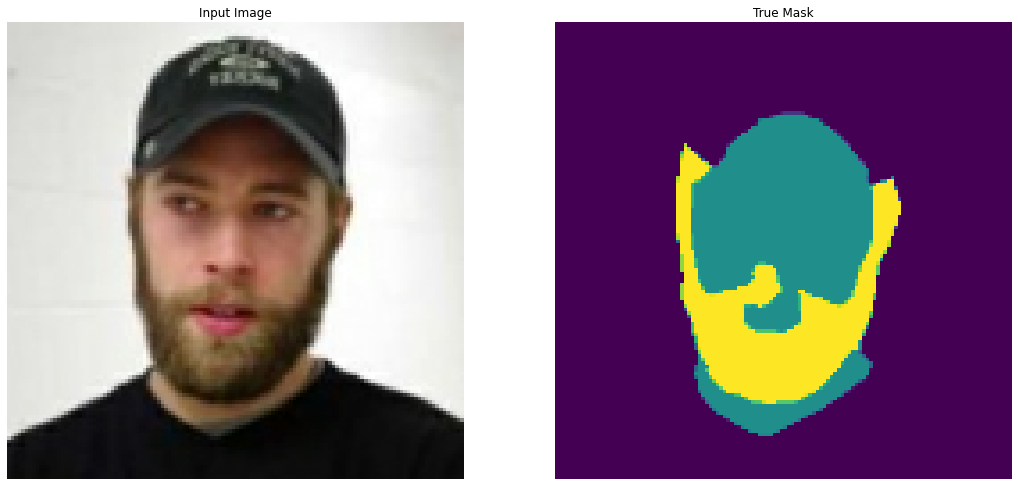

In [21]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

<h1>Building the model</h1>

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [25]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [26]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

In [34]:
def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        print("here")
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

In [29]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    print(sample_mask.shape)

(64, 128, 128, 1)


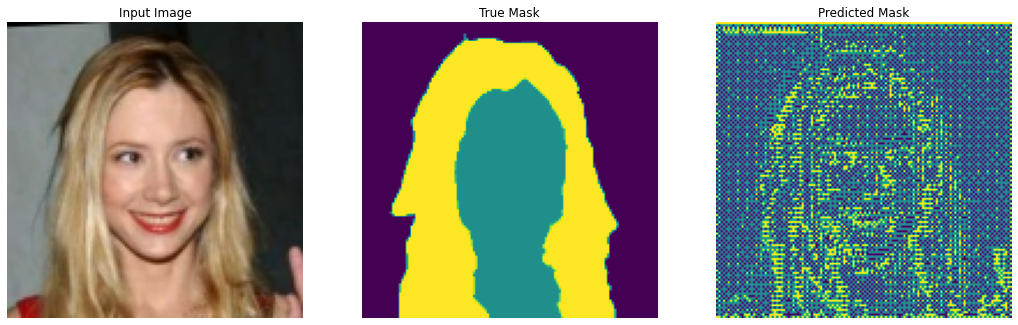

In [30]:
show_predictions()

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

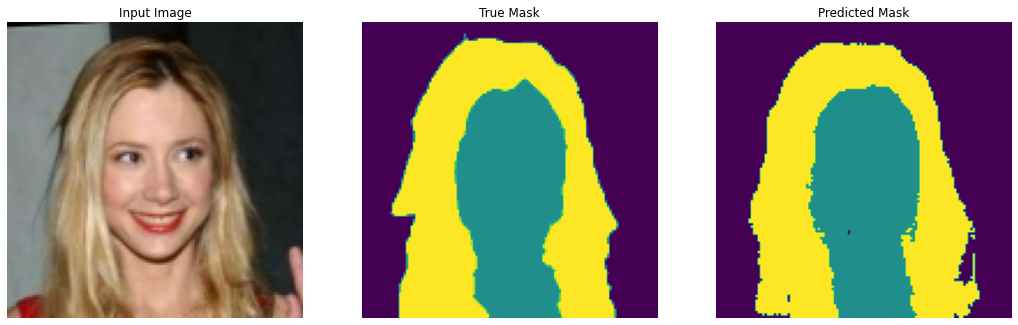


Sample Prediction after epoch 20



In [32]:
EPOCHS = 20

VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          callbacks=[DisplayCallback()])